In [13]:
import pandas as pd
import numpy as np
import json
from ast import literal_eval
import re

# === CONSTANTS ===
RATING_FILE = 'ratings_snap (1).csv'
USER_FILE = 'user_data.csv'
METADATA_FILE = 'movies_metadata.csv'
WATCH_FILE = 'watch.jsonl'
NEW_WATCH_FILE = 'watch_20250927_002128_1969102.jsonl'
CATALOG_SIZE = 27000

In [14]:
# === 1. LOAD & CLEAN DATA ===
print("Loading datasets...")

# Core datasets
users_df = pd.read_csv(USER_FILE)
ratings_df = pd.read_csv(RATING_FILE)
metadata_df = pd.read_csv(METADATA_FILE, low_memory=False)

# Load BOTH watch files with cleaning
def clean_watch_file(filepath):
    """Load and clean a single watch file."""
    with open(filepath, 'r') as f:
        # Fix corrupted timestamps (spaces, wT→T)
        cleaned_data = [json.loads(re.sub(r'(\d{4}-\d{2}-)\s*(\d{2})([T:])', r'\1\2\3', line).replace('wT', 'T')) 
                       for line in f]
    df = pd.DataFrame(cleaned_data)
    df['user_id'] = df['user_id'].astype(str)
    df['movie_id'] = df['movie_id'].astype(str)
    df['datetime'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df.dropna(subset=['datetime'], inplace=True)
    return df

# Load and combine watch data
watch_df = clean_watch_file(WATCH_FILE)
new_watch_df = clean_watch_file(NEW_WATCH_FILE)
all_watch_df = pd.concat([watch_df, new_watch_df], ignore_index=True)

# Standardize other IDs
ratings_df['user_id'] = ratings_df['user_id'].astype(str)
ratings_df['movie_id'] = ratings_df['movie_id'].astype(str)
users_df['user_id'] = users_df['user_id'].astype(str)
metadata_df['id'] = metadata_df['id'].astype(str)

print(f"Loaded: {len(ratings_df):,} ratings, {len(all_watch_df):,} watch events")


Loading datasets...
Loaded: 13,004 ratings, 1,980,215 watch events


In [15]:
# === 2. METRIC 1: GENRE HOMOGENIZATION (PrefRatio) ===
print("\n1. Genre Concentration Analysis")
def parse_genres(genres_str):
    try:
        return [g['name'] for g in literal_eval(genres_str)]
    except:
        return []

metadata_df['genres_list'] = metadata_df['genres'].apply(parse_genres)
metadata_clean = metadata_df[['id', 'genres_list']].explode('genres_list').rename(columns={'id': 'movie_id', 'genres_list': 'genre'})

# Calculate PrefRatio for ratings >= 4 (preferred items)
pref_df = (ratings_df.merge(users_df[['user_id', 'gender']], on='user_id', how='left')
                .merge(metadata_clean, on='movie_id', how='left')
                .query('rating >= 4 and genre.notna() and gender.notna()'))

# PrefRatio(g,c) = preferred movies in genre g / total preferred movies for demographic c
pref_df['GenrePrefCount'] = pref_df.groupby(['gender', 'genre'])['rating'].transform('count')
pref_df['TotalPrefCount'] = pref_df.groupby('gender')['rating'].transform('count')
pref_ratio = pref_df[['gender', 'genre', 'GenrePrefCount', 'TotalPrefCount']].drop_duplicates()
pref_ratio['PrefRatio'] = pref_ratio['GenrePrefCount'] / pref_ratio['TotalPrefCount']

# Max concentration per gender
max_F = pref_ratio[pref_ratio['gender']=='F']['PrefRatio'].max()
max_M = pref_ratio[pref_ratio['gender']=='M']['PrefRatio'].max()
top_F_genre = pref_ratio.loc[pref_ratio['PrefRatio']==max_F, 'genre'].iloc[0] if max_F > 0 else 'N/A'
top_M_genre = pref_ratio.loc[pref_ratio['PrefRatio']==max_M, 'genre'].iloc[0] if max_M > 0 else 'N/A'

print(f"Max Genre Concentration (F): {max_F:.4f} → {top_F_genre}")
print(f"Max Genre Concentration (M): {max_M:.4f} → {top_M_genre}")


1. Genre Concentration Analysis
Max Genre Concentration (F): 0.1766 → Drama
Max Genre Concentration (M): 0.1880 → Drama


In [21]:
# === 3. METRIC 2: LONG-TAIL COVERAGE ===
print("\n2. Long-tail Coverage")
unique_movies = pd.concat([ratings_df['movie_id'], all_watch_df['movie_id']]).nunique()
coverage_pct = (unique_movies / CATALOG_SIZE) * 100
print(f"Unique movies exposed: {unique_movies:,} / {CATALOG_SIZE:,}")
print(f"Catalog coverage: {coverage_pct:.1f}%")


2. Long-tail Coverage
Unique movies exposed: 15,056 / 27,000
Catalog coverage: 55.8%


In [17]:
# === 4. METRIC 3: POPULARITY EXPLOSION (Top-10% Concentration Trend) ===
print("\n3. Popularity Explosion Trend")
all_watch_df['week'] = all_watch_df['datetime'].dt.isocalendar().week
weekly_watches = all_watch_df.groupby(['week', 'movie_id']).size().reset_index(name='watch_count')

weekly_metrics = []
for week in sorted(weekly_watches['week'].unique()):
    week_data = weekly_watches[weekly_watches['week'] == week]
    if len(week_data) == 0:
        continue
        
    n_top10 = max(1, int(0.1 * len(week_data)))
    top10_watches = week_data.nlargest(n_top10, 'watch_count')['watch_count'].sum()
    total_watches = week_data['watch_count'].sum()
    top10_share = top10_watches / total_watches if total_watches > 0 else 0
    
    weekly_metrics.append({
        'week': week, 
        'total_watches': total_watches,
        'top10_share': top10_share,
        'n_movies': len(week_data)
    })

trend_df = pd.DataFrame(weekly_metrics)
print("\nWeekly Top-10% Watch Share:")
print(trend_df.round(4))

if len(trend_df) > 1:
    trend_change = trend_df['top10_share'].max() - trend_df['top10_share'].min()
    print(f"\nTrend: +{trend_change:.1%} change (Week {trend_df['week'].min()} → {trend_df['week'].max()})")


3. Popularity Explosion Trend

Weekly Top-10% Watch Share:
   week  total_watches  top10_share  n_movies
0    39        1936161       0.5364     12511
1    47          44054       0.8425      6590

Trend: +30.6% change (Week 39 → 47)


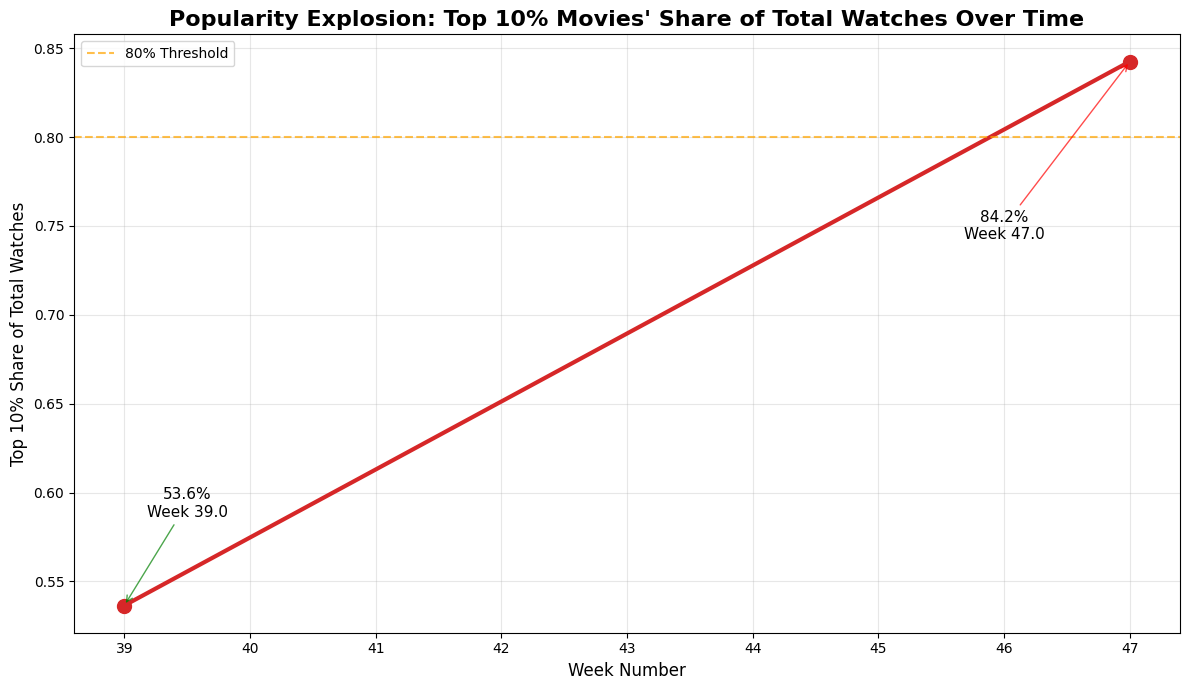

In [20]:
# === PLOT: Popularity Explosion Visualization ===
plt.figure(figsize=(12, 7))
plt.plot(trend_df['week'], trend_df['top10_share'], marker='o', linewidth=3, markersize=10, color='#d62728')
plt.axhline(y=0.8, color='orange', linestyle='--', alpha=0.7, label='80% Threshold')
plt.title('Popularity Explosion: Top 10% Movies\' Share of Total Watches Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Week Number', fontsize=12)
plt.ylabel('Top 10% Share of Total Watches', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Annotate key points
min_week = trend_df.loc[trend_df['top10_share'].idxmin()]
max_week = trend_df.loc[trend_df['top10_share'].idxmax()]
plt.annotate(f'{min_week.top10_share:.1%}\nWeek {min_week.week}', 
             xy=(min_week.week, min_week.top10_share), 
             xytext=(min_week.week+0.5, min_week.top10_share+0.05),
             arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
             fontsize=11, ha='center')
plt.annotate(f'{max_week.top10_share:.1%}\nWeek {max_week.week}', 
             xy=(max_week.week, max_week.top10_share), 
             xytext=(max_week.week-1, max_week.top10_share-0.1),
             arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
             fontsize=11, ha='center')

plt.tight_layout()
plt.show()

In [23]:
# === 5. FEEDBACK LOOP DIAGNOSIS ===
print("\n" + "="*60)
print("FEEDBACK LOOP DIAGNOSIS SUMMARY")
print("="*60)

genre_loop = "✓ PASS" if max_F > 0.15 or max_M > 0.15 else "✗ FAIL"
coverage_loop = "✓ PASS" if coverage_pct < 60 else "✗ FAIL" 
popularity_loop = "✓ PASS" if trend_df['top10_share'].max() > 0.8 else "⚠️  MARGINAL"

print(f"Genre Homogenization: {genre_loop} (>{15}% concentration)")
print(f"Long-tail Starvation: {coverage_loop} (<60% coverage)")
print(f"Popularity Explosion: {popularity_loop} (>{80}% top-10%)")

feedback_active = (max_F > 0.15 or max_M > 0.15) and coverage_pct < 60 and trend_df['top10_share'].max() > 0.8
print(f"\n🎯 FEEDBACK LOOP STATUS: {'CONFIRMED' if feedback_active else 'NOT DETECTED'}")

if feedback_active:
    print("\n→ High genre concentration + starved catalog + rising popularity concentration")
    print("→ Rich-get-richer dynamics confirmed across all metrics")
else:
    print("\n→ Mixed signals; additional data or refined thresholds needed")


FEEDBACK LOOP DIAGNOSIS SUMMARY
Genre Homogenization: ✓ PASS (>15% concentration)
Long-tail Starvation: ✓ PASS (<60% coverage)
Popularity Explosion: ✓ PASS (>80% top-10%)

🎯 FEEDBACK LOOP STATUS: CONFIRMED

→ High genre concentration + starved catalog + rising popularity concentration
→ Rich-get-richer dynamics confirmed across all metrics
